# Test the code for generating correlation matrices

In [1]:
import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Use this to load our modules.
module_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import src.correlations_sampler
importlib.reload(src.correlations_sampler)
from src.correlations_sampler import (check_positive_definite, 
                                      check_positive_semidefinite,
                                      project_matrix_to_psd,
                                      generate_random_correlation_matrix_using_optim,
                                      generate_random_correlation_matrix_using_trig,
                                     generate_random_correlation_matrix)

## Check that the basic projection works

In [3]:
np.random.seed(42)

matrix = np.random.uniform(-1, 1, size=(3, 3))
triu = np.triu(matrix, k=1)
matrix = triu + triu.T + np.eye(3)
projection, distance, elapsed_time = project_matrix_to_psd(matrix, constraint_indexes=None, verbose=True)
print('Original matrix', matrix)
print('Projected matrix', projection)
print('Distance', distance)
print('Elapsed time (ms)', elapsed_time)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 38
eps = 1.00e-10, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 7, constraints m = 38
Cones:	primal zero / dual free vars: 3
	linear vars: 18
	soc vars: 11, soc blks: 1
	sd vars: 6, sd blks: 1
Setup time: 2.43e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.86e+19  2.55e+19  1.00e+00 -3.68e+19  8.53e+19  2.43e+20  4.92e-02 
    45| 4.54e-12  2.19e-11  8.76e-11  2.26e-01  2.26e-01  5.99e-16  5.15e-02 
-----------------------------------------------

## Does it work under equality constraints for the correlation of specific variable pairs?

In [4]:
projection, distance, elapsed_time = project_matrix_to_psd(matrix, constraint_indexes={(1, 2)}, verbose=False)
print('Original matrix', matrix)
print('Projected matrix', projection)

Original matrix [[ 1.          0.90142861  0.46398788]
 [ 0.90142861  1.         -0.68801096]
 [ 0.46398788 -0.68801096  1.        ]]
Projected matrix [[ 1.          0.90142861  0.11736579]
 [ 0.90142861  1.         -0.32413882]
 [ 0.11736579 -0.32413882  1.        ]]


In [5]:
matrix, _ = generate_random_correlation_matrix_using_trig(nbr_columns=3, constraints=[0.8, 0.9])
print(matrix)

[[1.         0.79892491 0.8       ]
 [0.79892491 1.         0.9       ]
 [0.8        0.9        1.        ]]


In [6]:
np.random.seed(0)
matrix, _ = generate_random_correlation_matrix_using_trig(nbr_columns=4, constraints=[0.7, 0.8, 0.9])
print(matrix)

np.random.seed(42)
matrix, _ = generate_random_correlation_matrix_using_trig(nbr_columns=4, constraints=[0.7, 0.8, 0.9])
print(matrix)

[[1.         0.63187933 0.69397794 0.7       ]
 [0.63187933 1.         0.83255864 0.8       ]
 [0.69397794 0.83255864 1.         0.9       ]
 [0.7        0.8        0.9        1.        ]]
[[1.         0.94624928 0.7744337  0.7       ]
 [0.94624928 1.         0.84917791 0.8       ]
 [0.7744337  0.84917791 1.         0.9       ]
 [0.7        0.8        0.9        1.        ]]


## Is the method deterministic?

Do we generate the same matrix every time?


In [7]:
np.random.seed(42)
matrix = np.random.uniform(-1, 1, size=(3, 3))
triu = np.triu(matrix, k=1)
matrix = triu + triu.T + np.eye(3)
print('Original matrix', matrix)

np.random.seed(0)
projection, _, _ = project_matrix_to_psd(matrix)
print('Projected matrix', projection)

np.random.seed(1)
projection, _, _ = project_matrix_to_psd(matrix)
print('Projected matrix', projection)

Original matrix [[ 1.          0.90142861  0.46398788]
 [ 0.90142861  1.         -0.68801096]
 [ 0.46398788 -0.68801096  1.        ]]
Projected matrix [[ 1.          0.68010002  0.29421335]
 [ 0.68010002  1.         -0.5005768 ]
 [ 0.29421335 -0.5005768   1.        ]]
Projected matrix [[ 1.          0.68010002  0.29421335]
 [ 0.68010002  1.         -0.5005768 ]
 [ 0.29421335 -0.5005768   1.        ]]


## Comparison between the two initialization methods

1. The first method (`init_sym`) initializes a random correlation matrix with values $~ U(-1, 1)$.
2. The second method (`init_sym_diag_on`) initializes a random correlation matrix as above, except that the diagonal is set to 1. We expect this method to result in a projection matrix that's closer to the original random matrix. We also expect the optimization program to be quicker.

### Success rate

In [8]:
import time
def generate_matrices(nbr_trials, nbr_columns, constraints, initialization_optim, verbose=False):
    projections = []
    matrices = []
    distances = []
    elapsed_times = []
    for _ in range(nbr_trials):
        projection, matrix, distance, elapsed_time = generate_random_correlation_matrix_using_optim(
            nbr_columns, constraints, initialization_optim)
        # If the optimization was successful, save the results.
        try:
            if projection.ndim == 2:
                projections.append(projection)
                matrices.append(matrix)
                distances.append(distance)
                elapsed_times.append(elapsed_time)
        except:
            if verbose:
                print(projection, matrix, distance, elapsed_time)
    return projections, matrices, distances, elapsed_times

def generate_matrices_trig(nbr_trials, nbr_columns, K, constraints, shuffle_constraints=False):
    matrices = []
    elapsed_times = []
    for _ in range(nbr_trials):
        matrix,elapsed_time = generate_random_correlation_matrix_using_trig(
            nbr_columns, constraints, K=0.01, shuffle_constraints=shuffle_constraints)
        # If the optimization was successful, save the results.
        elapsed_times.append(elapsed_time * 1000)
        matrices.append(matrix)
    return matrices, None, None, elapsed_times

In [9]:
nbr_trials = 1000
nbr_columns = 4
K = 0.01
results_init_sym4 = generate_matrices(nbr_trials, nbr_columns, constraints={}, initialization_optim='sym')
results_init_sym_diag_one4 = generate_matrices(nbr_trials, nbr_columns, constraints={}, initialization_optim='sym_diag_one')
results_method_trig = generate_matrices_trig(nbr_trials, nbr_columns, K, constraints = [])

/data/ana-maria/miniconda3/envs/marginals/lib/python3.9/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [10]:
def success_rate(results, nbr_trials):
    nbr_trials = len(results[0])
    return np.sum([check_positive_semidefinite(results[0][i]) for i in range(nbr_trials)])/nbr_trials

print(f'Initialized with a symmetric matrix: {success_rate(results_init_sym4, nbr_trials):.2%}')
print(f'Initialized with a symmetric matrix + diag=1: {success_rate(results_init_sym_diag_one4, nbr_trials):.2%}')
print(f'Trigonometric method: {success_rate(results_method_trig, nbr_trials):.2%}')

Initialized with a symmetric matrix: 59.46%
Initialized with a symmetric matrix + diag=1: 56.90%
Trigonometric method: 100.00%


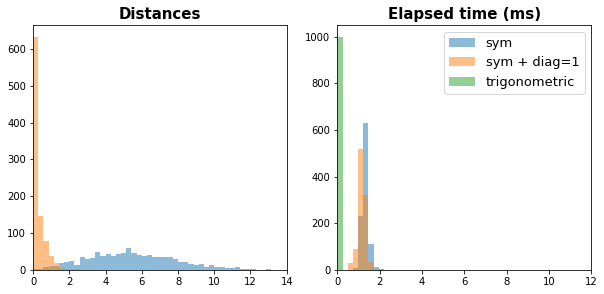

In [11]:
fig, axes  = plt.subplots(1, 2, figsize=(10, 4.5))
bins_distances = np.linspace(0, 14, 50)
axes[0].set_title('Distances', fontsize=15, fontweight='bold')
axes[0].hist(results_init_sym4[2], bins=bins_distances, alpha=0.5, label='sym')
axes[0].hist(results_init_sym_diag_one4[2], bins=bins_distances, alpha=0.5, label='sym + diag=1')
axes[0].set_xlim(0, 14)

bins_times = np.linspace(0, 12, 50)
axes[1].set_title('Elapsed time (ms)', fontsize=15, fontweight='bold')
axes[1].hist(results_init_sym4[3], bins=bins_times, alpha=0.5, label='sym')
axes[1].hist(results_init_sym_diag_one4[3], bins=bins_times, alpha=0.5, label='sym + diag=1')
axes[1].set_xlim(0, 12)
axes[1].hist(results_method_trig[3], bins=bins_times, alpha=0.5,label='trigonometric')
axes[1].legend(fontsize=13)

### Success rate with increasing number of columns

To print the exceptions (when a solution cannot be found), set `verbose=True`.

In [12]:
nbr_trials = 1000
nbrs_columns = list(range(3, 13))
results_init_sym = [generate_matrices(nbr_trials, nbr_columns, constraints={}, initialization_optim='sym') for nbr_columns in nbrs_columns]
results_init_sym_diag_one = [generate_matrices(nbr_trials, nbr_columns, constraints={}, initialization_optim='sym_diag_one') for nbr_columns in nbrs_columns]
results_method_trig = [generate_matrices_trig(nbr_trials, nbr_columns, 0.01, constraints=[]) for nbr_columns in nbrs_columns]

In [13]:
success_rate_init_sym = [success_rate(results_init_sym[i], nbr_trials) for i in range(len(nbrs_columns))]
success_rate_init_sym_diag_one = [success_rate(results_init_sym_diag_one[i], nbr_trials) for i in range(len(nbrs_columns))]
success_rate_method_trig = [success_rate(results_method_trig[i], nbr_trials) for i in range(len(nbrs_columns))]

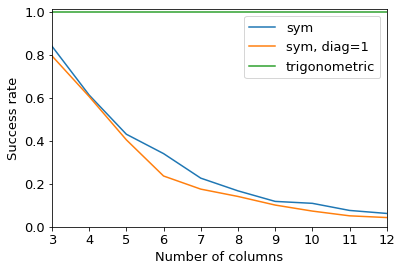

In [14]:
plt.plot(nbrs_columns, success_rate_init_sym, label='sym')
plt.plot(nbrs_columns, success_rate_init_sym_diag_one, label='sym, diag=1')
plt.plot(nbrs_columns, success_rate_method_trig, label='trigonometric')
plt.legend(fontsize=13)
plt.yticks(np.arange(0, 1.01, 0.2), fontsize=13)
plt.ylabel('Success rate', fontsize=13)
plt.ylim(0, 1.01)
plt.xlim(3, 10)
plt.xticks(nbrs_columns, fontsize=13)
plt.xlabel('Number of columns', fontsize=13)
plt.show()

### Check that the number of trials is consistent with the success rate

It should be close to 1/success rate.

In [15]:
np.random.seed(0)
nbrs_trials_sym = []
nbrs_trials_sym_diag_one = []
nbrs_trials_trig = []
for _ in range(1000):
    correlation_matrix_optim, nbr_trials_sym = generate_random_correlation_matrix(nbr_columns=10, constraints={}, 
                                                                    method='optim', initialization_optim='sym')
    nbrs_trials_sym.append(nbr_trials_sym)
    correlation_matrix_optim, nbr_trials_sym_diag_one = generate_random_correlation_matrix(nbr_columns=10, constraints={}, 
                                                                    method='optim', initialization_optim='sym_diag_one')
    nbrs_trials_sym_diag_one.append(nbr_trials_sym_diag_one)
    correlation_matrix_trig, nbr_trials_trig = generate_random_correlation_matrix(nbr_columns=10, constraints=[], 
                                                                    method='trigonometric', initialization_optim=None)
    nbrs_trials_trig.append(nbr_trials_trig)

(0.0, 75.0)

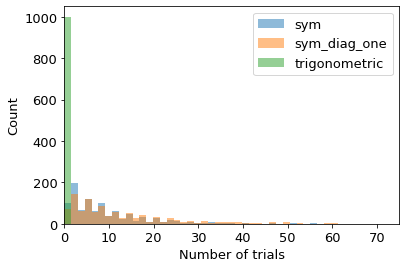

In [16]:
bins_trials = np.linspace(0, 75, 50)
plt.hist(nbrs_trials_sym, bins=bins_trials, alpha=0.5, label='sym')
plt.hist(nbrs_trials_sym_diag_one, bins=bins_trials,  alpha=0.5, label='sym_diag_one')
plt.hist(nbrs_trials_trig, bins=bins_trials, alpha=0.5, label = 'trigonometric')
plt.xlabel('Number of trials', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.tick_params(axis='both', labelsize=13)
plt.legend(fontsize=13)
plt.xlim(0, 75)

### How are the correlations distributed within each cell?

We know that correlations vary between -1 and 1. What ranges does our method cover?

In [17]:
print(type(results_init_sym[0][0]))

<class 'list'>


In [18]:
def visualization(correlation_matrices, constraint_indexes=set(), plot_type='', comparison=False):
    """"
    Allows to only visualize the values corresponding to elements that were not 
    constrained, and that are not on the diagonal.
    
    Use `comparison=True` to compare two methods side by side. Only enabled with `plot_type="vertical"`.
    """
    if comparison:
        assert len(correlation_matrices) == 3
        for i in range(3):
            correlation_matrices[i] = np.array(correlation_matrices[i]) #To allow for indexing.
        size = len(correlation_matrices[0][0])
    else:
        correlation_matrices = np.array(correlation_matrices)
        size = len(correlation_matrices[0])
    # Extract the indexes of correlations to plot.
    indexes_to_plot = set()
    constraint_indexes = set(constraint_indexes)
    for i in range(size):
        for j in range(i+1, size):
            if (i, j) not in constraint_indexes and (j, i) not in constraint_indexes:
                indexes_to_plot.add((i, j))
    indexes_to_plot = sorted(list(indexes_to_plot))
    print('Plotting the pairwise correlations for pairs: ', indexes_to_plot)
    
    bins = np.arange(-1, 1.01, 0.1)
       
    if plot_type == 'square':
        fig, axes = plt.subplots(size, size, figsize=(10, 6))
    
        for i in range(len(axes)):
            for j in range(len(axes)):
                if (i, j) in indexes_to_plot:
                    axes[i][j].hist(correlation_matrices[:, i, j], bins=bins, edgecolor='red',color='yellow')
                    axes[i][j].set_xlim(-1, 1)
                    axes[i][j].set_ylim(0, 100)
                    axes[i][j].set_title(f'corr(x{i+1}, x{j+1})', fontsize=15, fontweight='bold')
    elif plot_type == 'vertical':
        if comparison:
            colors = ['yellow', 'magenta', 'green']
            labels = ['sym', 'sym, diag=1', 'trigo']
            fig, axes = plt.subplots(len(indexes_to_plot), 3, figsize=(8, 2 * len(indexes_to_plot)))
            for idx, (i, j) in enumerate(indexes_to_plot):
                for k in range(3):
                    axes[idx][k].hist(correlation_matrices[k][:, i, j], bins=bins, edgecolor='k', color=colors[k], label=labels[k])
                    axes[idx][k].set_xlim(-1, 1)
                    axes[idx][k].set_ylim(0, 100)
                    if j+1 != 3 :
                        axes[idx][k].set_title(f'corr(x{i+1}, x{j+1})', fontsize=15, fontweight='bold')
                    else :
                        axes[idx][k].set_title(f'corr(x{i+1}, y)', fontsize=15, fontweight='bold')
                    if idx == 0:
                        axes[idx][k].legend(fontsize=13, loc='lower center')
        else:
            fig, axes = plt.subplots(len(indexes_to_plot), 1, figsize=(4, 2 * len(indexes_to_plot)))
            for idx, (i, j) in enumerate(indexes_to_plot):
                axes[idx].hist(correlation_matrices[:, i, j], bins=bins,density=True, edgecolor='red',color='yellow')
                axes[idx].set_xlim(-1, 1)
                axes[idx].set_ylim(0, 1)
                axes[idx].set_title(f'corr(x{i+1}, x{j+1})', fontsize=15, fontweight='bold')
    else:
        raise ValueError('ERROR: Unknown plot type.')
    
    plt.tight_layout()
    plt.show()

### Distribution of correlations for various number of columns

`nbr_columns = 3`

Plotting the pairwise correlations for pairs:  [(0, 1), (0, 2), (1, 2)]


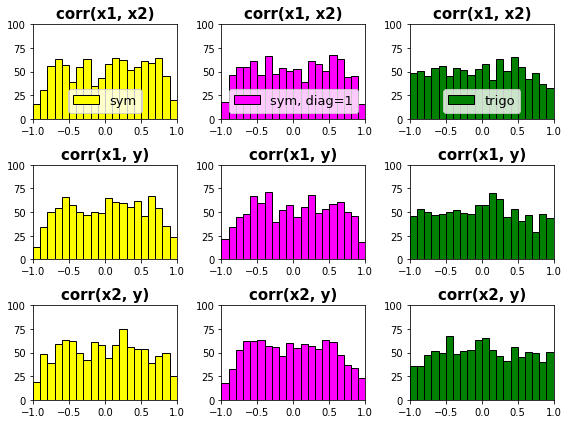

In [19]:
visualization([results_init_sym[0][0], results_init_sym_diag_one[0][0],results_method_trig[0][0]], plot_type='vertical', comparison=True)

`nbr_columns = 5`

Plotting the pairwise correlations for pairs:  [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


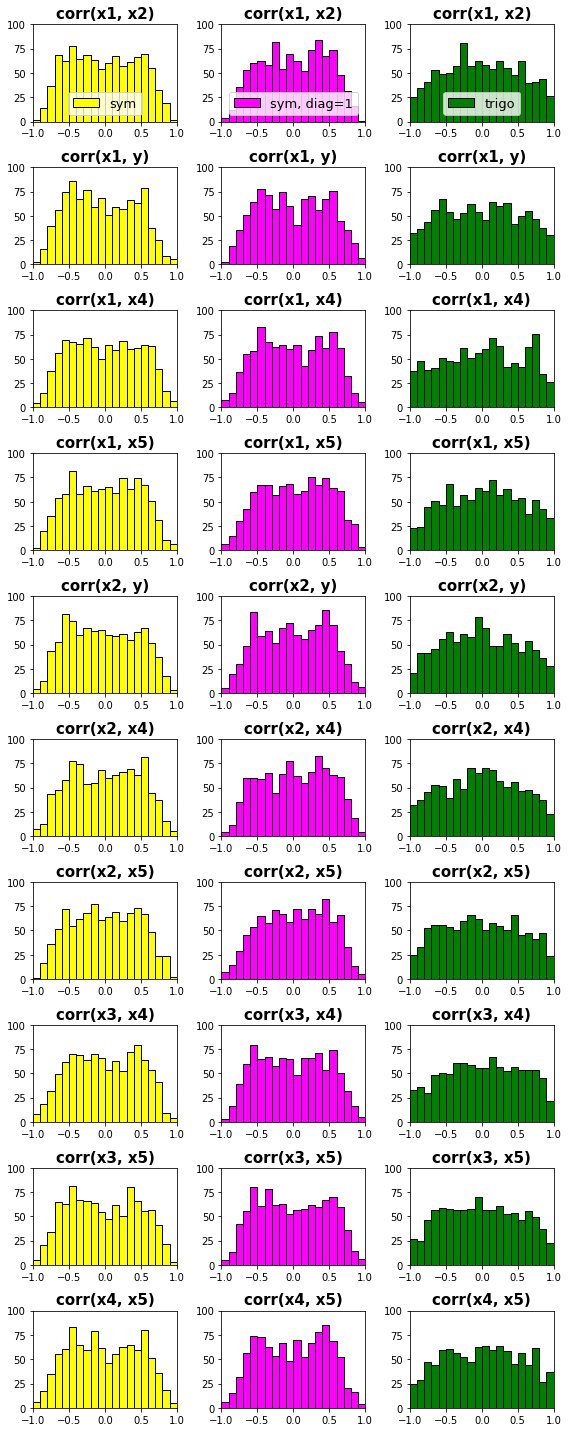

In [20]:
visualization([results_init_sym[2][0], results_init_sym_diag_one[2][0],results_method_trig[2][0]], plot_type='vertical', comparison=True)

`nbr_columns = 10`

Plotting the pairwise correlations for pairs:  [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]


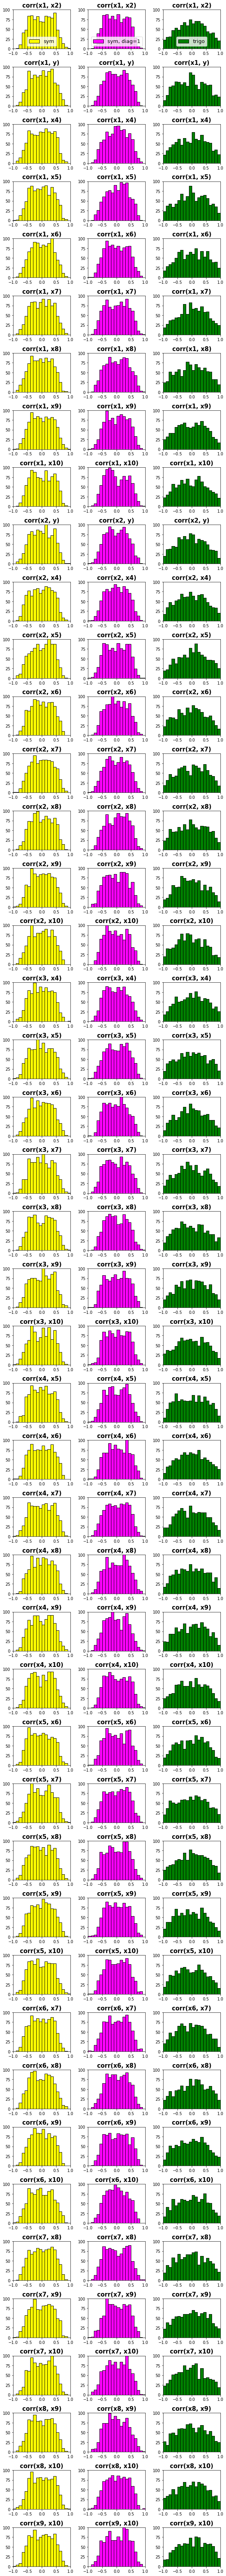

In [21]:
visualization([results_init_sym[7][0], results_init_sym_diag_one[7][0],results_method_trig[7][0]], plot_type='vertical', comparison=True)

In [22]:
correlation_matrix, nbr_trials = generate_random_correlation_matrix(nbr_columns=10, constraints=dict(), 
                                                                    method='optim', initialization_optim='sym_diag_one')
print(np.linalg.eigvals(correlation_matrix))

[3.10292937e+00 2.11743461e+00 2.31232178e+00 1.26393924e+00
 1.77179557e-01 5.65109115e-01 4.61086337e-01 3.29877088e-10
 1.33462612e-10 1.66494235e-10]


# Illustrate that the range can be restricted depending on the correlation constraints

We also check that the lower bound is always smaller than the upper bound

In [23]:
c1 = -0.5
c2 = -0.4
theta1, theta2 = math.acos(c1), math.acos(c2)
print(theta1, theta2)
bound1, bound2 = math.cos(theta1+theta2), math.cos(theta1-theta2)
print(bound1, bound2)
results_constraints = generate_matrices_trig(1000, 3, 0.01, constraints=[c1, c2])[0]
print(results_constraints[0])

2.0943951023931957 1.9823131728623846
-0.5937253933193772 0.9937253933193771
[[ 1.          0.81037741 -0.5       ]
 [ 0.81037741  1.         -0.4       ]
 [-0.5        -0.4         1.        ]]


Text(0.5, 1.0, 'corr(x1, x2)')

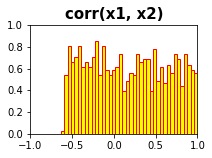

In [24]:
results_constraints = np.array(results_constraints)
fig, ax = plt.subplots(figsize=(3, 2))
ax.hist(results_constraints[:, 0, 1], bins=np.linspace(-1, 1, 50), density=True, edgecolor='red',color='yellow')
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.set_title(f'corr(x1, x2)', fontsize=15, fontweight='bold')

# Illustrate that the ordering of the constraints matters

We use $n=4$ columns and three constraints.

The constraints are shuffled to remove bias. Hence the distribution for rho(X1, X2) is not uniform but close to.
[[ 1.          0.33314902 -0.15760689 -0.5       ]
 [ 0.33314902  1.          0.0755589  -0.4       ]
 [-0.15760689  0.0755589   1.          0.6       ]
 [-0.5        -0.4         0.6         1.        ]]


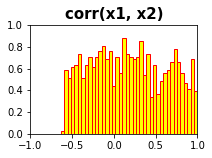

The constraints are not shuffled but rho(X1, X2) is sampled first hence its distribution is uniform.
[[ 1.          0.97635821  0.07216416 -0.5       ]
 [ 0.97635821  1.          0.08998418 -0.4       ]
 [ 0.07216416  0.08998418  1.          0.6       ]
 [-0.5        -0.4         0.6         1.        ]]


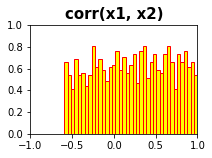

The constraints are not shuffled and rho(X1, X2) is sampled last hence its distribution is not uniform.
[[ 1.         -0.41615672  0.38564942  0.6       ]
 [-0.41615672  1.          0.32793673 -0.5       ]
 [ 0.38564942  0.32793673  1.         -0.4       ]
 [ 0.6        -0.5        -0.4         1.        ]]


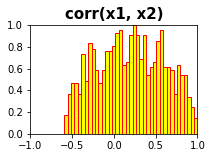

In [25]:
np.random.seed(0)

print('The constraints are shuffled to remove bias. Hence the distribution for rho(X1, X2) is not uniform but close to.')
c1, c2, c3 = [-0.5, -0.4, 0.6]
results_constraints = generate_matrices_trig(1000, 4, 0.01, constraints=[c1, c2, c3], shuffle_constraints=True)[0]
results_constraints = np.array(results_constraints)
print(results_constraints[0])
fig, ax = plt.subplots(figsize=(3, 2))
ax.hist(results_constraints[:, 0, 1], bins=np.linspace(-1, 1, 50), density=True, edgecolor='red',color='yellow')
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.set_title(f'corr(x1, x2)', fontsize=15, fontweight='bold')
plt.show()

print('The constraints are not shuffled but rho(X1, X2) is sampled first hence its distribution is uniform.')
c1, c2, c3 = [-0.5, -0.4, 0.6]
results_constraints = generate_matrices_trig(1000, 4, 0.01, constraints=[c1, c2, c3], shuffle_constraints=False)[0]
results_constraints = np.array(results_constraints)
print(results_constraints[0])
fig, ax = plt.subplots(figsize=(3, 2))
ax.hist(results_constraints[:, 0, 1], bins=np.linspace(-1, 1, 50), density=True, edgecolor='red',color='yellow')
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.set_title(f'corr(x1, x2)', fontsize=15, fontweight='bold')
plt.show()

print('The constraints are not shuffled and rho(X1, X2) is sampled last hence its distribution is not uniform.')
results_constraints = generate_matrices_trig(1000, 4, 0.01, constraints=[c3, c1, c2], shuffle_constraints=False)[0]
results_constraints = np.array(results_constraints)
print(results_constraints[0])
fig, ax = plt.subplots(figsize=(3, 2))
ax.hist(results_constraints[:, 1, 2], bins=np.linspace(-1, 1, 50), density=True, edgecolor='red',color='yellow')
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.set_title(f'corr(x1, x2)', fontsize=15, fontweight='bold')
plt.show()

In [26]:
results_constraints = generate_matrices_trig(1000, 5, 0.01, constraints=[0, 0.1, 0.2, 0.3], shuffle_constraints=True)[0]
print(results_constraints[0])

[[ 1.         -0.02066866 -0.04740082 -0.04767141  0.        ]
 [-0.02066866  1.         -0.07362582  0.93769322  0.1       ]
 [-0.04740082 -0.07362582  1.          0.20456652  0.2       ]
 [-0.04767141  0.93769322  0.20456652  1.          0.3       ]
 [ 0.          0.1         0.2         0.3         1.        ]]
